In [11]:
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from matplotlib.pyplot import figure, show
import seaborn as sns
from scipy import sparse
from scipy.sparse import linalg 
from scipy.sparse import dok_matrix
from scipy.sparse import csr_array
from scipy.sparse import find
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from itertools import zip_longest

df = pd.read_csv('../input/abcnews-date-text.csv')
nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))
df['tokenized'] = df.headline_text.str.split(' ')

df['length'] = df.tokenized.map(len)
df = df.loc[df.length > 1]


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
#explode and sanitize

ex = df.explode('tokenized')

ex = ex.loc[ex.tokenized.str.len() > 2]

ex = ex.loc[~ex.tokenized.isin(stopwords_set)]

In [13]:
#ceate dictionary of words

dictionary = ex.tokenized.drop_duplicates().sample(frac=1)

dictionary = pd.Series(dictionary.tolist(), name='words')

dictionary = dictionary.to_frame()

dictionary_lookup = dictionary.to_dict()['words']

dictionary['encode'] = dictionary.index + 1

dictionary = dictionary.set_index('words')

dictionary.encode = dictionary.encode
dictionary = dictionary.to_dict()['encode']


In [14]:

encode = ex.tokenized.map(dictionary.get).to_frame()

In [15]:
#reduced grouping to series and aggregated to tuple
#improved from 30s to 20s
encode.index.astype('int')
encode.tokenized.astype('int')
docs = encode.tokenized.groupby(level=0).agg(tuple)


In [16]:

encoded_docs = list(zip(*zip_longest(*docs.to_list(), fillvalue=0)))

encoded_docs = csr_array(encoded_docs, dtype=int)

row_column_code = find(encoded_docs)

word_sorted_index = row_column_code[2].argsort()

doc_word = np.array([row_column_code[0][word_sorted_index], row_column_code[2][word_sorted_index]])

doc_word_sorted_index = doc_word[0].argsort()

doc_word = pd.DataFrame(np.array([doc_word[0][doc_word_sorted_index], doc_word[1][doc_word_sorted_index]]).T, columns=['doc','word'])

doc_word.word = doc_word.word - 1

doc_word_count  = doc_word.groupby(['doc','word']).size().to_frame('count').reset_index().to_numpy().T

sparse_doc_word_matrix = csr_array((doc_word_count[2],(doc_word_count[0],doc_word_count[1])), shape=(np.size(encoded_docs, 0),len(dictionary)), dtype=float)


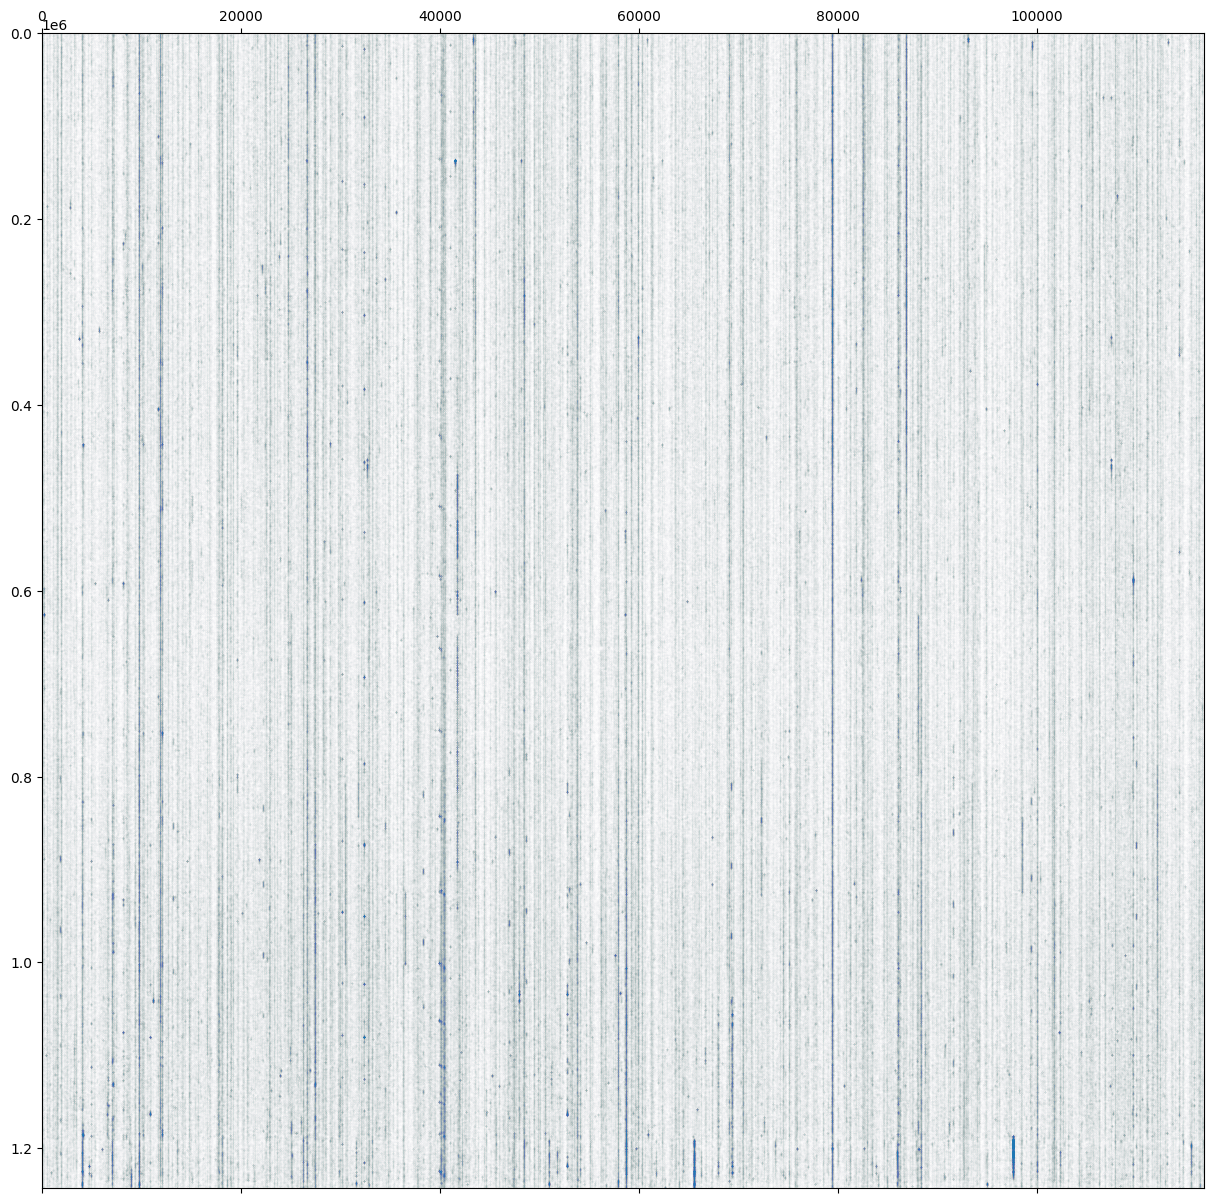

In [17]:

from matplotlib.pyplot import figure, show
import numpy

fig = figure(figsize=[15, 15])
sparse_doc_word_matrix_visualization = fig.add_subplot(1,1,1)

sparse_doc_word_matrix_visualization.spy(sparse_doc_word_matrix, markersize=0.0016, aspect = 'auto')



<Axes: >

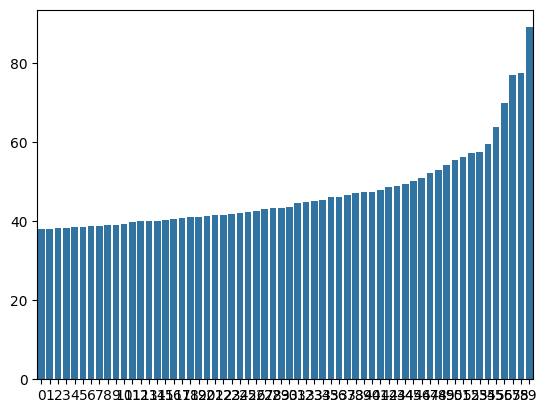

In [21]:
# 1.06 TiB for an array with shape (1242915, 116795)
#sparse_doc_word_matrix.toarray()

normalized_sparse_doc_word_matrix = normalize(sparse_doc_word_matrix)

documents, concepts, terms = svds(normalized_sparse_doc_word_matrix, k=60)


fig = figure()
singular_values = fig.add_subplot(1,1,1)
 
sns.barplot(ax=singular_values,x=list(range(len(concepts))),y=concepts)



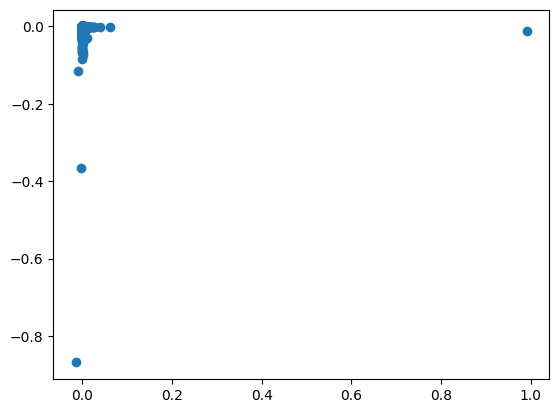

In [23]:

normalized_terms = normalize(terms)

svd_terms_visualizatinon = plt.scatter(normalized_terms[56],normalized_terms[59])

svd_terms_visualizatinon

In [24]:
terms_df = pd.DataFrame(np.argsort(normalized_terms).T)
terms_df.applymap(dictionary_lookup.get)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
0,urged,one,melbourne,minister,north,boost,set,china,first,accused,...,govt,fire,council,man,govt,says,police,man,new,police
1,minister,year,wins,killed,school,funding,melbourne,south,accused,win,...,nsw,govt,govt,council,council,govt,new,charged,man,man
2,woman,claims,open,set,queensland,north,woman,first,wins,school,...,australia,nsw,court,fire,fire,council,man,court,says,new
3,car,woman,urged,school,korea,indigenous,open,coronavirus,farmers,one,...,urged,qld,plan,govt,nsw,australia,investigate,murder,council,charged
4,attack,wins,minister,accused,urged,budget,wins,funding,found,china,...,man,rural,says,nsw,court,nsw,probe,dies,australia,court
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116790,killed,set,dies,car,funding,year,farmers,talks,school,minister,...,court,man,coronavirus,faces,charged,charged,john,hunt,officer,freewilly
116791,melbourne,melbourne,queensland,funding,boost,attack,claims,north,home,dies,...,crash,water,world,murder,police,interview,nrl,investigate,hunt,trentlee
116792,farmers,urged,coronavirus,boost,coronavirus,school,attack,attack,win,murder,...,house,plan,south,face,new,police,michael,probe,probe,ausindotsunami
116793,hit,attack,world,one,minister,south,dies,minister,murder,wins,...,council,australia,day,accused,man,man,extended,new,investigate,bustanul
